# Setup and data ingestion

In [67]:
library(conflicted)

library(xtable)
library(scales)
library(tikzDevice)

# Data manipulation
library(tidyverse)
conflict_prefer("filter", "dplyr")
conflict_prefer("select", "dplyr")
library(reshape2)
library(ggpubr)

# Data loading
library(jsonlite)
library(writexl)
library(readxl)

[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::filter over any other package
[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::select over any other package


In [68]:
# Workbook settings
options(repr.matrix.max.rows=50, repr.matrix.max.cols=30)

In [69]:
get_rel_file <- function(file) {
#     return(file.path("output", "2018-12-07_2019-01-05", file))
    return(file.path("output", "2018-12-07_2019-03-19", file))
}

In [70]:
datafile <- bzfile(get_rel_file("out2.json.bz2"), open='r')
data <- stream_in(datafile, flatten=TRUE)
close(datafile)

 Imported 29863 records. Simplifying...


In [71]:
data$treatment.ethnicity <- as.factor(data$treatment.ethnicity)
data$treatment.gender <- as.factor(data$treatment.gender)
data$type <- as.factor(data$type)
data$scraper <- as.factor(data$scraper)
data$block_id <- as.factor(data$block_id)
data$agent_id <- as.factor(data$agent_id)
data$time <- as.POSIXct(data$time)

In [72]:
levels(data$scraper)

[1] "BBCAdScraper"                 "ChicagoReaderScraper"        
 [3] "ChicagoTribuneScraper"        "CNNAdScraper"                
 [5] "FoxChampaignScraper"          "GoogleSearchAdScraper"       
 [7] "HomeFinderAdScraper"          "NewsGazetteAdScraper"        
 [9] "NewsGazetteRealEstateScraper" "RealtorRanking"              
[11] "RedfinScraper"                "SunTimesAdScraper"           
[13] "TruliaScraper"                "WCIAScraper"                 
[15] "ZillowSaleScraper"            "ZillowScraper"

In [73]:
rankings <- data[data$type == 'ranking', ]
rankings <- rankings[!is.null(rankings$ranking), ]
rankings$ad.image_path <- NULL
rankings$ad.title <- NULL
rankings$ad.url <- NULL
rankings$ad.body <- NULL

In [74]:
format_ranking <- function(df) {
    df$idx <- seq.int(nrow(df))
    df$position <- log(df$idx)
    if ("price" %in% colnames(df)) {
        df$price <- parse_number(df$price)
    }
    if("beds" %in% colnames(df)) {
        df$beds[df$beds == "Studio"] <- "0"
        df$beds <- parse_number(df$beds, na = c("", "NA"))
    }
    if("baths" %in% colnames(df)) {
        df$baths <- parse_number(df$baths)
    }
    if("latitude" %in% colnames(df)) {
        df$latitude <- parse_number(df$latitude)
        df$longitude <- parse_number(df$longitude)
    }
    return(df)
}

# Trulia rankings

## Data setup

In [75]:
nestedTruliaRankings <- rankings %>%
    filter(scraper == 'TruliaScraper')

nestedTruliaRankings$ranking <- lapply(nestedTruliaRankings$ranking, format_ranking)
nrow(nestedTruliaRankings)

[1] 846

In [76]:
min(nestedTruliaRankings$time)
max(nestedTruliaRankings$time)
max(nestedTruliaRankings$time) - min(nestedTruliaRankings$time)

[1] "2018-11-21 17:02:05 CST"

[1] "2019-03-19 17:56:43 CDT"

Time difference of 117.9963 days

In [78]:
truliaRankings <- unnest(nestedTruliaRankings, ranking)
colnames(truliaRankings)[colnames(truliaRankings)=="street address"] <- "street_address"

# truliaRankings %>%
#    filter(price > 1500000) %>%
#    count(treatment.gender, treatment.ethnicity)

# truliaRankings <- truliaRankings %>%
#     filter(url == 'https://www.trulia.com/IL/Chicago/') %>%
#     filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
#     filter(url == 'https://www.trulia.com/IL/Chicago/' | url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/')
#     filter(!is.na(street_address))
#     filter(price <= 1500000)

# nrow(truliaRankings)

In [18]:
truliaRankings %>%
    filter(price <= 1500000) %>%
    filter(url == 'https://www.trulia.com/IL/Chicago/') %>%
#     filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
    group_by(treatment.gender, treatment.ethnicity) %>%
    summarise(avg=mean(price), sd=sd(price), n=n())

truliaRankings %>%
    filter(price <= 1500000) %>%
#     filter(url == 'https://www.trulia.com/IL/Chicago/') %>%
    filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
    group_by(treatment.gender, treatment.ethnicity) %>%
    summarise(avg=mean(price), sd=sd(price), n=n()) 

treatment.gender,treatment.ethnicity,avg,sd,n
female,african-american,168605.8,108441.5,360
female,asian,170438.2,111625.7,343
female,caucasian,167585.4,109025.3,326
female,hispanic,169962.4,110061.7,350
male,african-american,167955.5,107855.7,368
male,asian,170753.5,112402.7,335
male,caucasian,167829.9,106959.1,369
male,hispanic,169022.1,110392.2,363


treatment.gender,treatment.ethnicity,avg,sd,n
female,african-american,211871.5,125303.6,670
female,asian,211399.2,124990.8,670
female,caucasian,215972.7,131233.2,650
female,hispanic,212214.0,126709.8,690
male,african-american,214731.0,129515.4,700
male,asian,217588.4,133160.6,720
male,caucasian,213385.9,129501.1,710
male,hispanic,214387.5,126593.1,600


In [607]:
truliaRankings %>%
    filter(price <= 1500000) %>%
#     filter(url == 'https://www.trulia.com/IL/Chicago/') %>%
    filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
    count()
#     group_by(treatment.gender, treatment.ethnicity) %>%
#     summarise(avg=mean(price), sd=sd(price), n=n())

n
5410


In [578]:
str(truliaRankings)

'data.frame':	9552 obs. of  24 variables:
 $ time               : POSIXct, format: "2018-12-15 16:40:58" "2018-12-15 16:40:58" ...
 $ type               : Factor w/ 2 levels "ad","ranking": 2 2 2 2 2 2 2 2 2 2 ...
 $ scraper            : Factor w/ 16 levels "BBCAdScraper",..: 13 13 13 13 13 13 13 13 13 13 ...
 $ treatment_id       : chr  "hispanic-female" "hispanic-female" "hispanic-female" "hispanic-female" ...
 $ url                : chr  "https://www.trulia.com/IL/Chicago/" "https://www.trulia.com/IL/Chicago/" "https://www.trulia.com/IL/Chicago/" "https://www.trulia.com/IL/Chicago/" ...
 $ agent_id           : Factor w/ 1082 levels "0046fcf8-8bb2-40d2-b20f-3659e5745d60",..: 173 173 173 173 173 173 173 173 173 173 ...
 $ block_id           : Factor w/ 1 level "1": 1 1 1 1 1 1 1 1 1 1 ...
 $ query              : chr  NA NA NA NA ...
 $ treatment.gender   : Factor w/ 2 levels "female","male": 1 1 1 1 1 1 1 1 1 1 ...
 $ treatment.ethnicity: Factor w/ 4 levels "african-american",..: 4 4 

## Marketwide analysis

### Correlation between demographics and price on index

#### All results

In [611]:
res.trulia <- aov(idx ~ treatment.gender * treatment.ethnicity * price, data=truliaRankings)
# summary(res.trulia) %>% xtable() %>% print()
coefficients(res.trulia)

(Intercept) 
                                           7.492897e+00 
                                   treatment.gendermale 
                                          -5.977409e-02 
                               treatment.ethnicityasian 
                                           3.027732e-02 
                           treatment.ethnicitycaucasian 
                                          -1.893723e-01 
                            treatment.ethnicityhispanic 
                                          -2.450094e-02 
                                                  price 
                                          -1.818842e-08 
          treatment.gendermale:treatment.ethnicityasian 
                                          -2.481115e-02 
      treatment.gendermale:treatment.ethnicitycaucasian 
                                           1.729809e-01 
       treatment.gendermale:treatment.ethnicityhispanic 
                                           2.419621e-01 
                             treatment.gendermale:price 
                                          -2.076612e-08 
                         treatment.ethnicityasian:price 
                                           1.125215e-08 
                     treatment.ethnicitycaucasian:price 
                                           1.211965e-08 
                      treatment.ethnicityhispanic:price 
                                           8.611605e-09 
    treatment.gendermale:treatment.ethnicityasian:price 
                                           3.902976e-08 
treatment.gendermale:treatment.ethnicitycaucasian:price 
                                          -1.382398e-08 
 treatment.gendermale:treatment.ethnicityhispanic:price 
                                          -1.777707e-08

#### Top 20

In [192]:
res.trulia <- aov(idx ~ treatment.ethnicity * treatment.gender * price, data=filter(truliaRankings, idx <= 20))
summary(res.trulia)

                                             Df Sum Sq Mean Sq F value   Pr(>F)
treatment.ethnicity                           3      5    1.82   0.123 0.946350
treatment.gender                              1      0    0.17   0.012 0.914338
price                                         1    212  212.27  14.412 0.000148
treatment.ethnicity:treatment.gender          3      3    1.07   0.073 0.974612
treatment.ethnicity:price                     3      0    0.05   0.003 0.999767
treatment.gender:price                        1      0    0.22   0.015 0.902368
treatment.ethnicity:treatment.gender:price    3      1    0.34   0.023 0.995195
Residuals                                  7884 116123   14.73                 
                                              
treatment.ethnicity                           
treatment.gender                              
price                                      ***
treatment.ethnicity:treatment.gender          
treatment.ethnicity:price                    

#### Top 10

In [193]:
res.trulia <- aov(idx ~ treatment.ethnicity * treatment.gender * price, data=filter(truliaRankings, idx <= 10))
summary(res.trulia)

                                             Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                           3      0    0.00   0.000 1.0000
treatment.gender                              1      0    0.00   0.000 1.0000
price                                         1     70   70.45   8.531 0.0035
treatment.ethnicity:treatment.gender          3      0    0.00   0.000 1.0000
treatment.ethnicity:price                     3      0    0.08   0.010 0.9986
treatment.gender:price                        1      0    0.41   0.050 0.8237
treatment.ethnicity:treatment.gender:price    3      1    0.31   0.037 0.9905
Residuals                                  7334  60565    8.26               
                                             
treatment.ethnicity                          
treatment.gender                             
price                                      **
treatment.ethnicity:treatment.gender         
treatment.ethnicity:price                    
treatment.gender:price

#### Top 5

In [194]:
res.trulia <- aov(idx ~ treatment.ethnicity * treatment.gender * price, data=filter(truliaRankings, idx <= 5))
summary(res.trulia)

                                             Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                           3      0  0.0000   0.000  1.000
treatment.gender                              1      0  0.0000   0.000  1.000
price                                         1      0  0.2558   0.127  0.721
treatment.ethnicity:treatment.gender          3      0  0.0000   0.000  1.000
treatment.ethnicity:price                     3      1  0.3891   0.194  0.901
treatment.gender:price                        1      0  0.2047   0.102  0.749
treatment.ethnicity:treatment.gender:price    3      5  1.6847   0.839  0.472
Residuals                                  3659   7343  2.0069               

#### Top 3

In [195]:
res.trulia <- aov(idx ~ treatment.ethnicity * treatment.gender * price, data=filter(truliaRankings, idx <= 3))
summary(res.trulia)

                                             Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                           3    0.0  0.0000   0.000  1.000
treatment.gender                              1    0.0  0.0000   0.000  1.000
price                                         1    1.5  1.5114   2.255  0.133
treatment.ethnicity:treatment.gender          3    0.0  0.0002   0.000  1.000
treatment.ethnicity:price                     3    0.1  0.0279   0.042  0.989
treatment.gender:price                        1    0.1  0.1057   0.158  0.691
treatment.ethnicity:treatment.gender:price    3    0.8  0.2789   0.416  0.741
Residuals                                  2189 1467.5  0.6704               

### Correlation between demographics and index on price

#### All results

In [593]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=truliaRankings)
# summary(res.trulia) %>% xtable(display=c("s","d","g","g","f","f")) %>% print(math.style.exponents = TRUE)
xtable(res.trulia) %>%
  print(booktabs = TRUE)

% latex table generated in R 3.4.4 by xtable 1.8-3 package
% Tue May  7 20:42:05 2019
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrr}
  \toprule
 & Df & Sum Sq & Mean Sq & F value & Pr($>$F) \\ 
  \midrule
treatment.ethnicity & 3 & 9083833238670.66 & 3027944412890.22 & 0.19 & 0.9006 \\ 
  treatment.gender & 1 & 275458746578.95 & 275458746578.95 & 0.02 & 0.8943 \\ 
  idx & 1 & 25138931068324.79 & 25138931068324.79 & 1.61 & 0.2045 \\ 
  treatment.ethnicity:treatment.gender & 3 & 2228573534232.25 & 742857844744.08 & 0.05 & 0.9863 \\ 
  treatment.ethnicity:idx & 3 & 9817297436984.82 & 3272432478994.94 & 0.21 & 0.8898 \\ 
  treatment.gender:idx & 1 & 5922015375075.53 & 5922015375075.53 & 0.38 & 0.5380 \\ 
  treatment.ethnicity:treatment.gender:idx & 3 & 6618307088867.45 & 2206102362955.82 & 0.14 & 0.9353 \\ 
  Residuals & 8434 & 131702140751824096.00 & 15615620198224.34 &  &  \\ 
   \bottomrule
\end{tabular}
\end{table}


#### Top 20

In [197]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=filter(truliaRankings, idx <= 20))
summary(res.trulia)

                                           Df    Sum Sq   Mean Sq F value
treatment.ethnicity                         3 1.236e+13 4.119e+12   0.259
treatment.gender                            1 5.185e+10 5.185e+10   0.003
idx                                         1 2.295e+14 2.295e+14  14.412
treatment.ethnicity:treatment.gender        3 3.802e+12 1.267e+12   0.080
treatment.ethnicity:idx                     3 3.227e+12 1.076e+12   0.068
treatment.gender:idx                        1 2.118e+11 2.118e+11   0.013
treatment.ethnicity:treatment.gender:idx    3 2.002e+12 6.673e+11   0.042
Residuals                                7884 1.255e+17 1.592e+13        
                                           Pr(>F)    
treatment.ethnicity                      0.855179    
treatment.gender                         0.954494    
idx                                      0.000148 ***
treatment.ethnicity:treatment.gender     0.971094    
treatment.ethnicity:idx                  0.977151    
treatment.

#### Top 10

In [198]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=filter(truliaRankings, idx <= 10))
summary(res.trulia)

                                           Df    Sum Sq   Mean Sq F value
treatment.ethnicity                         3 1.318e+13 4.395e+12   0.257
treatment.gender                            1 9.345e+10 9.345e+10   0.005
idx                                         1 1.460e+14 1.460e+14   8.531
treatment.ethnicity:treatment.gender        3 3.975e+12 1.325e+12   0.077
treatment.ethnicity:idx                     3 2.667e+12 8.889e+11   0.052
treatment.gender:idx                        1 6.834e+11 6.834e+11   0.040
treatment.ethnicity:treatment.gender:idx    3 2.862e+12 9.539e+11   0.056
Residuals                                7334 1.255e+17 1.711e+13        
                                         Pr(>F)   
treatment.ethnicity                      0.8565   
treatment.gender                         0.9411   
idx                                      0.0035 **
treatment.ethnicity:treatment.gender     0.9722   
treatment.ethnicity:idx                  0.9844   
treatment.gender:idx        

#### Top 5

In [199]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=filter(truliaRankings, idx <= 5))
summary(res.trulia)

                                           Df    Sum Sq   Mean Sq F value
treatment.ethnicity                         3 4.603e+12 1.534e+12   0.088
treatment.gender                            1 5.707e+10 5.707e+10   0.003
idx                                         1 2.227e+12 2.227e+12   0.127
treatment.ethnicity:treatment.gender        3 4.205e+12 1.402e+12   0.080
treatment.ethnicity:idx                     3 9.316e+12 3.105e+12   0.178
treatment.gender:idx                        1 2.088e+12 2.088e+12   0.120
treatment.ethnicity:treatment.gender:idx    3 4.224e+13 1.408e+13   0.806
Residuals                                3659 6.390e+16 1.747e+13        
                                         Pr(>F)
treatment.ethnicity                       0.967
treatment.gender                          0.954
idx                                       0.721
treatment.ethnicity:treatment.gender      0.971
treatment.ethnicity:idx                   0.911
treatment.gender:idx                      0.73

#### Top 3

In [200]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=filter(truliaRankings, idx <= 3))
summary(res.trulia)

                                           Df    Sum Sq   Mean Sq F value
treatment.ethnicity                         3 1.804e+13 6.013e+12   0.347
treatment.gender                            1 1.137e+12 1.137e+12   0.066
idx                                         1 3.909e+13 3.909e+13   2.255
treatment.ethnicity:treatment.gender        3 1.318e+13 4.393e+12   0.253
treatment.ethnicity:idx                     3 3.860e+12 1.287e+12   0.074
treatment.gender:idx                        1 1.216e+12 1.216e+12   0.070
treatment.ethnicity:treatment.gender:idx    3 1.598e+13 5.328e+12   0.307
Residuals                                2189 3.794e+16 1.733e+13        
                                         Pr(>F)
treatment.ethnicity                       0.791
treatment.gender                          0.798
idx                                       0.133
treatment.ethnicity:treatment.gender      0.859
treatment.ethnicity:idx                   0.974
treatment.gender:idx                      0.79

### Correlation between demographics on price

#### All results

In [201]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=truliaRankings)
summary(res.trulia)

                                       Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                     3 9.084e+12 3.028e+12   0.194  0.901
treatment.gender                        1 2.755e+11 2.755e+11   0.018  0.894
treatment.ethnicity:treatment.gender    3 2.122e+12 7.074e+11   0.045  0.987
Residuals                            8442 1.317e+17 1.561e+13               

#### Top 20

In [202]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=filter(truliaRankings, idx <= 20))
summary(res.trulia)

                                       Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                     3 1.236e+13 4.119e+12   0.258  0.855
treatment.gender                        1 5.185e+10 5.185e+10   0.003  0.955
treatment.ethnicity:treatment.gender    3 3.558e+12 1.186e+12   0.074  0.974
Residuals                            7892 1.258e+17 1.593e+13               

#### Top 10

In [203]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=filter(truliaRankings, idx <= 10))
summary(res.trulia)

                                       Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                     3 1.318e+13 4.395e+12   0.257  0.857
treatment.gender                        1 9.345e+10 9.345e+10   0.005  0.941
treatment.ethnicity:treatment.gender    3 3.975e+12 1.325e+12   0.077  0.972
Residuals                            7342 1.257e+17 1.711e+13               

#### Top 5

In [204]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=filter(truliaRankings, idx <= 5))
summary(res.trulia)

                                       Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                     3 4.603e+12 1.534e+12   0.088  0.967
treatment.gender                        1 5.707e+10 5.707e+10   0.003  0.954
treatment.ethnicity:treatment.gender    3 4.205e+12 1.402e+12   0.080  0.971
Residuals                            3667 6.396e+16 1.744e+13               

#### Top 3

In [205]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=filter(truliaRankings, idx <= 3))
summary(res.trulia)

                                       Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                     3 1.804e+13 6.013e+12   0.348  0.791
treatment.gender                        1 1.137e+12 1.137e+12   0.066  0.798
treatment.ethnicity:treatment.gender    3 1.318e+13 4.393e+12   0.254  0.859
Residuals                            2197 3.800e+16 1.730e+13               

#### Top Result

In [206]:
res.trulia <- aov(price ~ treatment.ethnicity * treatment.gender, data=filter(truliaRankings, idx == 1))
summary(res.trulia)

                                      Df    Sum Sq   Mean Sq F value Pr(>F)
treatment.ethnicity                    3 8.280e+12 2.760e+12   0.144  0.934
treatment.gender                       1 3.256e+12 3.256e+12   0.170  0.680
treatment.ethnicity:treatment.gender   3 8.596e+12 2.865e+12   0.149  0.930
Residuals                            727 1.394e+16 1.918e+13               

### Demographic comparisons

#### By price

In [573]:
truliaRankings %>%
    filter(price <= 1500000) %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.ethnicity,treatment.gender,price
african-american,female,204216.6
african-american,male,205580.3
asian,female,205097.1
asian,male,208957.1
caucasian,female,207585.3
caucasian,male,205139.9
hispanic,female,205524.9
hispanic,male,205291.4


In [123]:
truliaRankings %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.ethnicity,price
african-american,1356969
asian,1166113
caucasian,1289416
hispanic,1266158


In [34]:
truliaRankings %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.gender,price
female,591297.8
male,581728.4


##### Top 10

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

##### Top 5

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

#### By Size

In [ ]:
truliaRankings %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

##### Top 10

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 10) %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

##### Top 5

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

In [ ]:
truliaRankings %>%
    filter(idx <= 5) %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(beds), mean, na.rm = TRUE)

# Realtor.com

## Data setup

In [79]:
nestedRealtorRankings <- rankings %>%
    filter(scraper == 'RealtorRanking')

nestedRealtorRankings$ranking <- lapply(nestedRealtorRankings$ranking, format_ranking)
nrow(nestedRealtorRankings)

[1] 436

In [80]:
max(nestedRealtorRankings$time)
min(nestedRealtorRankings$time)
max(nestedRealtorRankings$time) - min(nestedRealtorRankings$time)

[1] "2019-03-19 17:32:10 CDT"

[1] "2018-12-07 12:43:04 CST"

Time difference of 102.1591 days

In [81]:
realtorRankings <- unnest(nestedRealtorRankings, ranking)
colnames(realtorRankings)[colnames(realtorRankings)=="street address"] <- "street_address"
realtorRankings <- realtorRankings
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Chicago_IL' | url == 'https://www.realtor.com/realestateandhomes-search/Champaign_IL') %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Chicago_IL') %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Champaign_IL') %>%
#     filter(!is.na(street_address)) %>%
#     filter(price <= 1500000)

realtorRankings %>%
    count()

# str(realtorRankings)
# nrow(unique(realtorRankings[c("street_address", "locality")]))

n
6600


## Marketwide Analysis

### Correlation between demographics and price on index

In [594]:
res.realtor <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=realtorRankings)
# summary(res.realtor)
# coefficients(res.realtor)

# tmp %>%
xtable(res.realtor) %>%
  print(booktabs = TRUE)

% latex table generated in R 3.4.4 by xtable 1.8-3 package
% Tue May  7 20:43:01 2019
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrr}
  \toprule
 & Df & Sum Sq & Mean Sq & F value & Pr($>$F) \\ 
  \midrule
treatment.ethnicity & 3 & 70619634926.71 & 23539878308.90 & 0.21 & 0.8886 \\ 
  treatment.gender & 1 & 326198946136.38 & 326198946136.38 & 2.93 & 0.0870 \\ 
  idx & 1 & 19783873336630.02 & 19783873336630.02 & 177.67 & 0.0000 \\ 
  treatment.ethnicity:treatment.gender & 3 & 394573553434.31 & 131524517811.44 & 1.18 & 0.3153 \\ 
  treatment.ethnicity:idx & 3 & 275230349059.39 & 91743449686.46 & 0.82 & 0.4805 \\ 
  treatment.gender:idx & 1 & 583448351282.05 & 583448351282.05 & 5.24 & 0.0221 \\ 
  treatment.ethnicity:treatment.gender:idx & 3 & 177796317208.98 & 59265439069.66 & 0.53 & 0.6602 \\ 
  Residuals & 6545 & 728797045075124.38 & 111351725756.32 &  &  \\ 
   \bottomrule
\end{tabular}
\end{table}


In [604]:
res.realtor <- aov(price ~ treatment.ethnicity * treatment.gender * idx, data=filter(realtorRankings, idx <= 40))
# summary(res.realtor)
xtable(res.realtor) %>%
  print(booktabs = TRUE)

% latex table generated in R 3.4.4 by xtable 1.8-3 package
% Tue May  7 20:57:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrr}
  \toprule
 & Df & Sum Sq & Mean Sq & F value & Pr($>$F) \\ 
  \midrule
treatment.ethnicity & 3 & 51999513887.65 & 17333171295.88 & 0.36 & 0.7790 \\ 
  treatment.gender & 1 & 2968433600.20 & 2968433600.20 & 0.06 & 0.8028 \\ 
  idx & 1 & 6219294324052.60 & 6219294324052.60 & 130.62 & 0.0000 \\ 
  treatment.ethnicity:treatment.gender & 3 & 37235355803.58 & 12411785267.86 & 0.26 & 0.8538 \\ 
  treatment.ethnicity:idx & 3 & 37976144752.47 & 12658714917.49 & 0.27 & 0.8500 \\ 
  treatment.gender:idx & 1 & 57672894697.84 & 57672894697.84 & 1.21 & 0.2711 \\ 
  treatment.ethnicity:treatment.gender:idx & 3 & 26910640424.00 & 8970213474.67 & 0.19 & 0.9043 \\ 
  Residuals & 5419 & 258016505961131.94 & 47613306137.87 &  &  \\ 
   \bottomrule
\end{tabular}
\end{table}


In [156]:
# coefficients(res.realtor)

In [157]:
length(unique(realtorRankings$street_address))

[1] 103

In [158]:
mean(realtorRankings$price)

[1] 224143.1

### Demographic comparison

In [159]:
realtorRankings %>%
    filter(!is.na(street_address)) %>%
    group_by(treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.gender,price
female,222428.2
male,225674.8


In [160]:
realtorRankings %>%
    filter(!is.na(street_address)) %>%
#     filter(idx == 1) %>%
    group_by(treatment.ethnicity) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.ethnicity,price
african-american,224534.7
asian,223256.2
caucasian,224547.2
hispanic,224264.1


In [161]:
realtorRankings %>%
    filter(!is.na(street_address)) %>%
    filter(price <= 1500000) %>%
    
    group_by(treatment.ethnicity, treatment.gender) %>%
    summarise_at(vars(price), mean, na.rm = TRUE)

treatment.ethnicity,treatment.gender,price
african-american,female,224921.7
african-american,male,224172.6
asian,female,226058.7
asian,male,220708.5
caucasian,female,220961.4
caucasian,male,227589.7
hispanic,female,217756.3
hispanic,male,230006.2


# Plots

In [56]:
realtor_prices <- realtorRankings %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Chicago_IL') %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Champaign_IL') %>%
    group_by(idx) %>%
    filter(price <= 1500000) %>%
    summarise(price = mean(price)/10000)
realtor_prices$site <- "Realtor.com"

trulia_prices <- truliaRankings %>%
#     filter(url == "https://www.trulia.com/IL/Chicago/") %>%
#     filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
    group_by(idx) %>%
    filter(price <= 1500000) %>%
    summarise(price = mean(price)/10000)
trulia_prices$site <- "Trulia.com"

prices <- rbind(realtor_prices, trulia_prices)

In [57]:
realtor_prices <- realtorRankings %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Chicago_IL') %>%
#     filter(url == 'https://www.realtor.com/realestateandhomes-search/Champaign_IL') %>%
    group_by(idx) %>%
    filter(price <= 1500000) %>%
    count()
# realtor_prices

# trulia_prices <- truliaRankings %>%
# #     filter(url == "https://www.trulia.com/IL/Chicago/") %>%
# #     filter(url == 'https://www.trulia.com/County/IL/Champaign_Real_Estate/' | url == 'https://www.trulia.com/IL/Champaign/') %>%
#     group_by(idx) %>%
#     filter(price <= 1500000) %>%
#     count()
# trulia_prices

# realtorRankings %>%
#     group_by(idx) %>%
#     summarize(time = max(time))

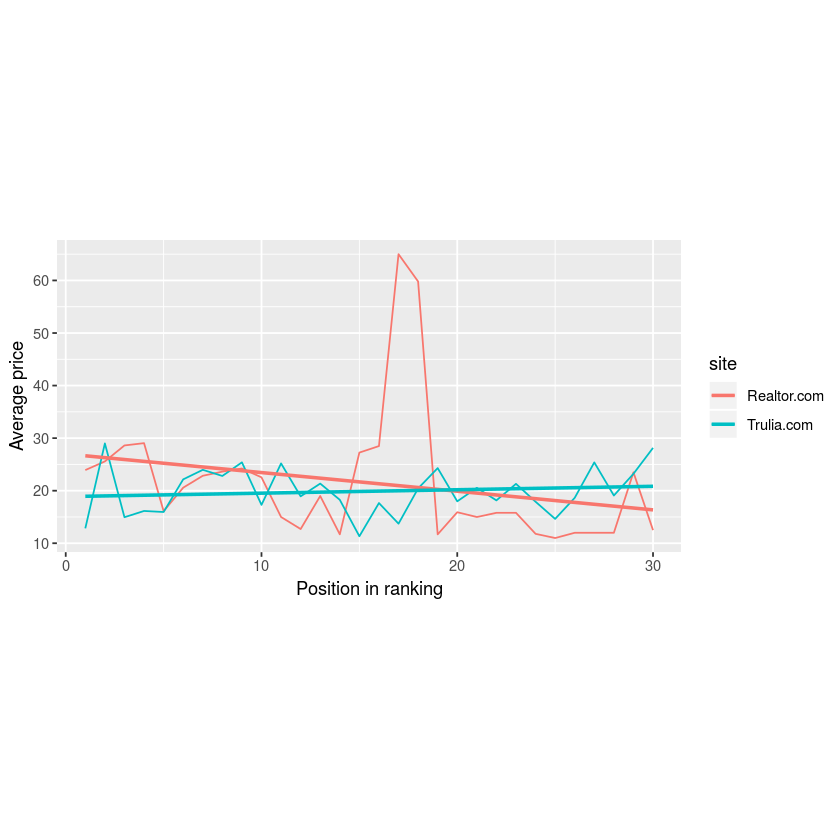

In [20]:
p <- ggplot(data=prices, mapping=aes(x=idx, y=price, color=site)) + 
    scale_x_continuous(name="Position in ranking") + 
    scale_y_continuous(name="Average price", labels = scales::comma) + 
    geom_line() + 
    geom_smooth(method = "lm", se = FALSE) +
    theme(aspect.ratio=0.50) +
    coord_fixed(.000008)

# ggsave('trends.png', p)
# print(p)
# dev.off()
p

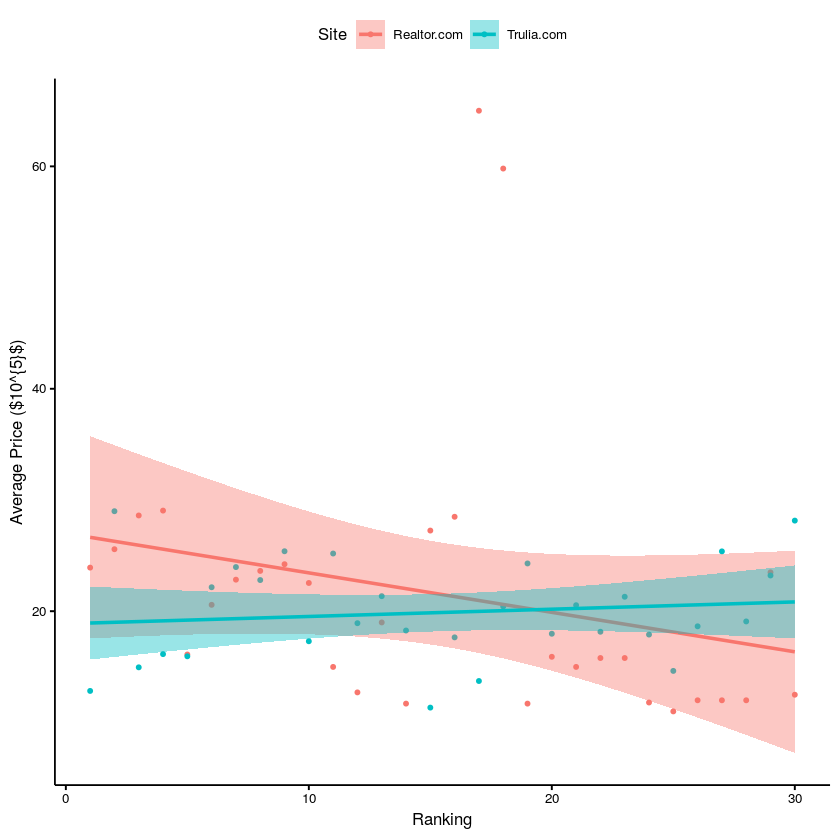

In [22]:
p <- ggscatter(prices, x="idx", y="price", color="site",
          xlab = "Ranking", ylab = "Average Price ($10^{5}$)",
          size = 1.0,
          add = "reg.line", conf.int = TRUE) +
    font("axis.text", size = 8) +
    font("axis.title", size = 10) +
    font("legend.text", size = 8) +
    font("legend.title", size = 10)

p <- ggpar(p, legend.title = "Site")
p

In [569]:
tikz('trends.tex', width = 3.31314, height = 2.20876)
print(p)
dev.off()

png 
  2

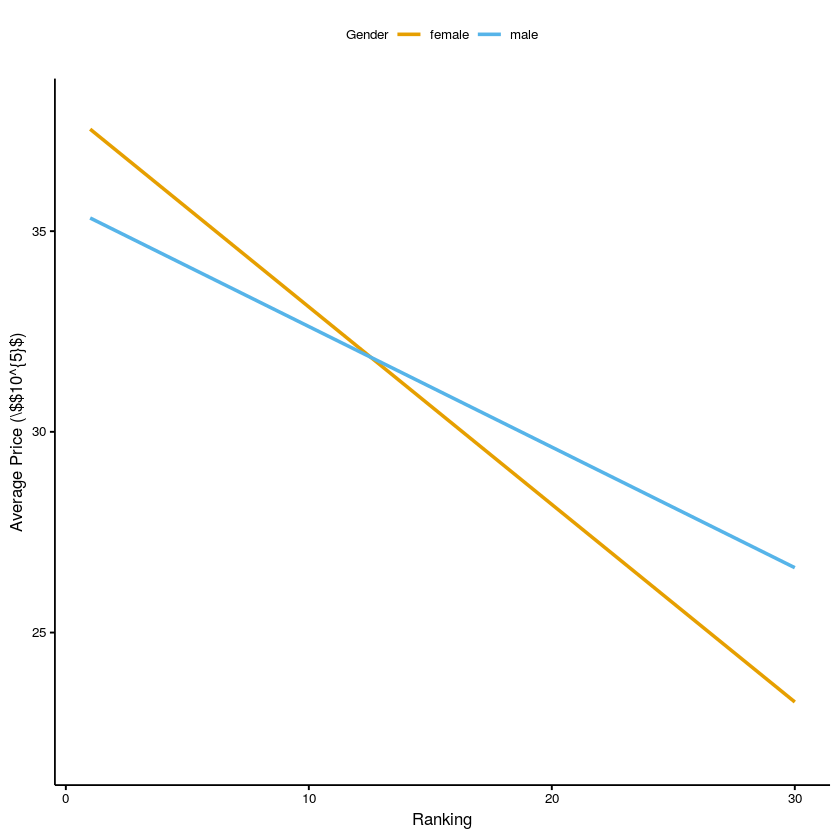

In [127]:
realtor_trends <- realtorRankings %>%
    filter(url == 'https://www.realtor.com/realestateandhomes-search/Chicago_IL') %>%
#     filter(price <= 1500000) %>%
    group_by(idx, treatment.gender) %>%
    summarise(price = mean(price)/10000) %>%
    filter(price <= 1500000)

p <- ggscatter(realtor_trends, x="idx", y="price", color="treatment.gender",
            xlab = "Ranking", ylab = "Average Price (\\$$10^{5}$)",
#             ylab = "Average Price (\\$$10^{5}$)",
            point = FALSE,
            size = 1.0,
            add = "reg.line") +
    font("axis.text", size = 8) +
    font("axis.title", size = 10) +
    font("legend.text", size = 8) +
    font("legend.title", size = 8)

p <- set_palette(p, palette = c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"))

# p <- ggpar(p, legend.title = "Site")
p <- ggpar(p, legend = "None", legend.title = "Gender", ylim = c(22, 38))

p

In [131]:
tikz('realtor-gender.tex', width = 3, height = 2)
print(p)
dev.off()

png 
  2

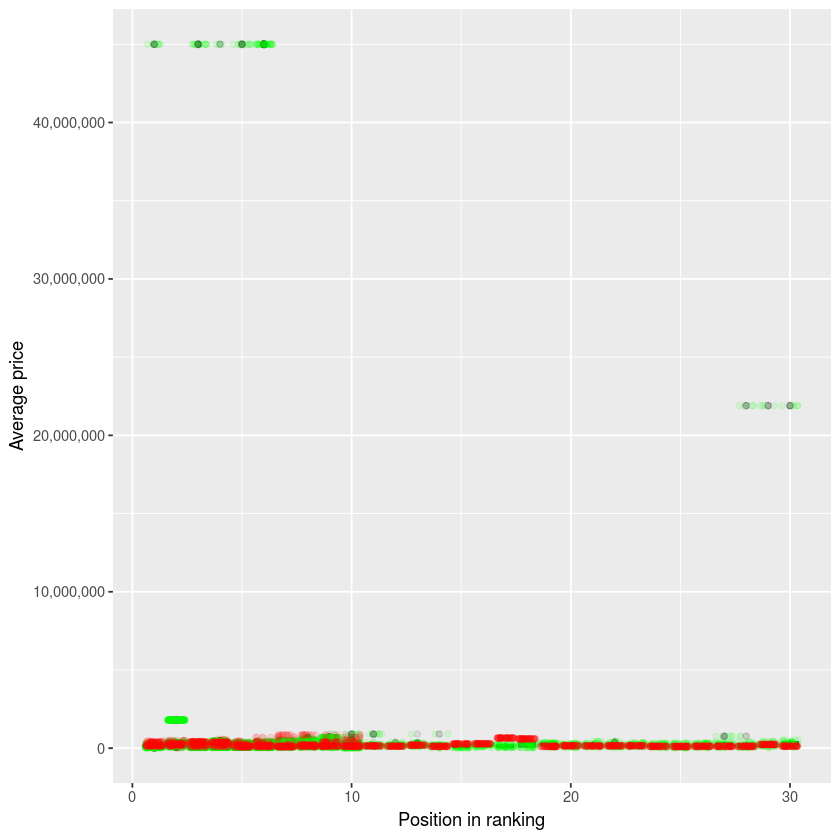

In [25]:
p <- ggplot() + 
    scale_x_continuous(name="Position in ranking") + 
    scale_y_continuous(name="Average price", labels = scales::comma) + 
    geom_boxplot(alpha=0.1, data=truliaRankings, mapping=aes(x=idx, y=price, group=idx)) +
    geom_jitter(alpha=0.1, data=truliaRankings, mapping=aes(x=idx, y=price), color='green') +
    geom_jitter(alpha=0.1, data=realtorRankings, mapping=aes(x=idx, y=price), color='red') +
    geom_smooth(method = "lm")

p

# Redfin

In [ ]:
# redfinRankings <- rankings[rankings$scraper == 'RedfinScraper', ]
# redfinRankings$ranking <- lapply(redfinRankings$ranking, format_ranking)
# unnestedRedfinRankings <- unnest(redfinRankings, ranking)
# str(unnestedRedfinRankings)
# res.redfin <- aov(position ~ treatment.ethnicity * treatment.gender * price, data=unnestedRedfinRankings)
# summary(res.redfin)